# Gradient-Based Optimization

In [1]:
import SQcircuit as sq

import torch
from matplotlib import pyplot as plt

## Introduction

In this notebook, we demonstrate the gradient-based optimization capability of `SQcircuit`. This can be used to optimize a wide variety of targets including decoherence/dephasing rates, flux and charge dispersion, and coupling strengths. In short, any differentiable function of the circuit's eigenfrequencies/vectors or element values that can be expressed in PyTorch may be optimized over. 

Here we focus on the specific case of optimizing a circuit's parameters for a target operation frequency $\omega^*_{10}$.

To begin using SQcircuit with backpropagation enabled, we first activate the PyTorch engine:

In [2]:
sq.set_engine('PyTorch')

In this notebook, we consider optimization over a fluxonium circuit. The circuit diagram looks like the following:

<div align="center">
<img src="pics/Fluxonium.png" width="300"/>
</div>

## Circuit Construction

In the following cell, we define the circuit elements and create a fluxonium circuit from these elements.

The `requires_grad` attribute of each element defines whether we will optimize over that element's value later. In this example, we only optimize over the value of the junction.

In [3]:
# Define loop
loop = sq.Loop(0.5, requires_grad = False)

# Define elements
J = sq.Junction(13, 'GHz', loops = [loop], requires_grad = True)
C = sq.Capacitor(5, 'fF', requires_grad = False)
L = sq.Inductor(400, 'nH', loops = [loop], requires_grad = False)

elements = {
    (0, 1): [J, L, C],
}

# Create circuit from elements
fluxonium = sq.Circuit(elements)
fluxonium.set_trunc_nums([400, ])

In [4]:
fluxonium.parameters

[tensor(8.1681e+10, dtype=torch.float64, requires_grad=True)]

The next step is to diagonalize the circuit. This returns the first $n=2$ eigenvalues and eigenvectors, which we can use to build a more complex loss function.

In [5]:
efreqs, evecs = fluxonium.diag(2)
print(f"Eigenvalues shape: {efreqs.shape}")
print(f"Eigenvectors shape: {evecs.shape}")

Eigenvalues shape: torch.Size([2])
Eigenvectors shape: torch.Size([2, 400])


Let's start by printing the target operation frequency of our qubit:

In [6]:
def get_resonant_frequency(circuit):
  eigenvalues, _ = circuit.diag(2)
  omega = (eigenvalues[1] - eigenvalues[0])
  return omega

omega_10 = get_resonant_frequency(fluxonium)
print(f"Starting frequency: {omega_10} GHz")

Starting frequency: 0.4736612667648745 GHz


## Loss Function

We can now define our loss function in terms of the output $\omega$, for a target operation frequency of $\omega^*=2.4$ GHz. For consistency, we convert everything from GHz to Hz.

In [7]:
omega_target = 2.4 # GHz

def compute_loss(circuit, omega_target):
  omega = get_resonant_frequency(circuit)
  loss = (omega * 1e9 - omega_target * 1e9) ** 2
  return loss

initial_loss = compute_loss(fluxonium, omega_target)
print(f"Initial loss: {initial_loss}")

Initial loss: 3.710780915162121e+18


## Optimization

The circuit stores the values of all its component elements which require gradient in its `.parameters` attribute. These are the values of the circuit which can be optimized.

In this case, that's just the junction.

In [8]:
fluxonium.parameters

[tensor(8.1681e+10, dtype=torch.float64, requires_grad=True)]

Using the loss function `compute_loss` defined above, we optimize `fluxonium.parameters` using PyTorch's SGD optimizer. See PyTorch's [documentation](https://pytorch.org/docs/stable/optim.html) for more information on how to use the optimizers.

In [9]:
# Initialize the optimizer with the fluxonium's parameters (the JJ value)
optimizer = torch.optim.SGD(
    fluxonium.parameters,
    lr=1e2
)

# Save a record of the loss, junction value, and qubit frequency at each
# iteration.
loss_record, J_record, frequency_record = [], [], []

for epoch in range(50):
  # Print current iteration
  print(f"Iteration #{epoch}")
  # and current junction value
  J_value = J.get_value('GHz')
  print(f"J value: {J_value} GHz")
  J_record.append(J_value.detach().numpy())

  # Zero the gradient from the previous iteration
  optimizer.zero_grad()
  
  # Compute qubit frequency
  omega = get_resonant_frequency(fluxonium)
  frequency_record.append(omega.detach().numpy())
  print(f"Frequency: {omega} GHz")

  # Compute loss
  loss = compute_loss(fluxonium, omega_target)
  loss_record.append(loss.detach().numpy())
  print(f"Loss: {loss}\n")

  # Perform backpropagation
  loss.backward()

  # Step the optimizer. The will change the junction value.
  optimizer.step()

  # After changing the value of the element, we need to recompute the
  # circuit, which is done by calling `.update()`.
  fluxonium.update()

Iteration #0
J value: 81.68140899333463 GHz
Frequency: 0.4736612667648741 GHz
Loss: 3.7107809151619763e+18

Iteration #1
J value: 77.50707158432445 GHz
Frequency: 0.5214667184930293 GHz
Loss: 3.5288872897289953e+18

Iteration #2
J value: 72.96279918337451 GHz
Frequency: 0.5798962526125435 GHz
Loss: 3.3127776512534984e+18

Iteration #3
J value: 67.99200866924963 GHz
Frequency: 0.6525354108932899 GHz
Loss: 3.0536324901815644e+18

Iteration #4
J value: 62.533208781254146 GHz
Frequency: 0.7444802883780293 GHz
Loss: 2.7407455155688074e+18

Iteration #5
J value: 56.52865836620794 GHz
Frequency: 0.8629123898121358 GHz
Loss: 2.362638321393239e+18

Iteration #6
J value: 49.947653694671075 GHz
Frequency: 1.0174862833834641 GHz
Loss: 1.9113441766323182e+18

Iteration #7
J value: 42.84147095099205 GHz
Frequency: 1.2193354509392225 GHz
Loss: 1.3939687774088494e+18

Iteration #8
J value: 35.4547925923707 GHz
Frequency: 1.4752874770986604 GHz
Loss: 8.5509325001072e+17

Iteration #9
J value: 28.387441

Let's take a look at our results! We can first observe how the loss changes over time:

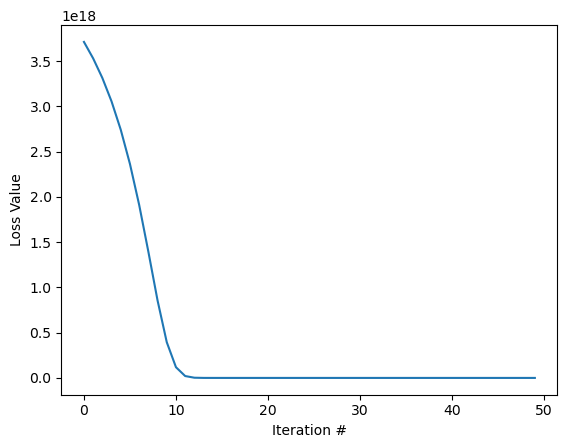

In [10]:
# Plot loss values
plt.xlabel('Iteration #')
plt.ylabel('Loss Value')
plt.plot(loss_record)

Then to ensure our circuit changes as intended as the loss function is reduced, we can also measure the convergence of our qubit frequency to the desired target frequency $\omega^*_{10} = 2.4$ GHz, and look at how $E_J$ is optimized to achieve that:

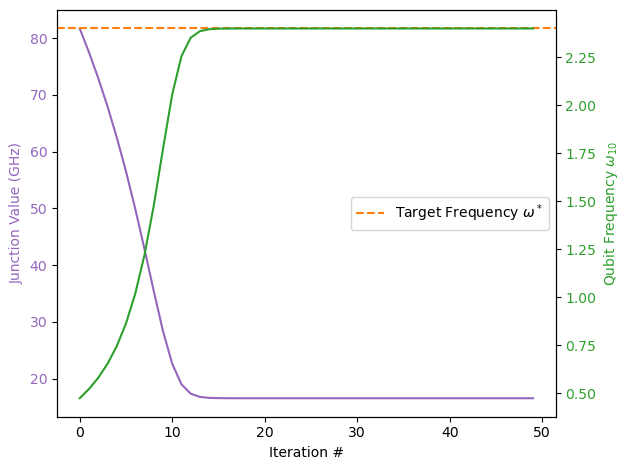

In [11]:
# Plot junction value vs. qubit frequency
fig, ax1 = plt.subplots()

color = 'tab:purple'
ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Junction Value (GHz)', color=color)
ax1.plot(J_record, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel(r'Qubit Frequency $\omega_{10}$', color=color)
ax2.axhline(y=omega_target, xmin=0, xmax=50,
            color='tab:orange', ls='--', label=r'Target Frequency $\omega^*$')
ax2.plot(frequency_record, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='center right')

fig.tight_layout()
plt.show()